In [1]:
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)
import csv
from pathlib import Path

currentdir = os.path.dirname(os.path.realpath('cell_polygons.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

Downloading: "https://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
100%|██████████| 25.2M/25.2M [00:02<00:00, 9.39MB/s]
Downloading: "https://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:02<00:00, 12.2MB/s]
Downloading: "https://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:02<00:00, 10.5MB/s]
Downloading: "https://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:03<00:00, 7.52MB/s]
Downloading: "https://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 8.13MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_0" to /root/.cellpose/models/cytotorch_0
100%|██████████| 25.3M/25.3M [00:02<00:00, 10.4MB/s]
Downloading: "https://www.cellpose.org/models/cytotorch_1" to /root/.cellpose/models/cytotorch_1
100%|██████████| 25.3M/25.3M [00:02

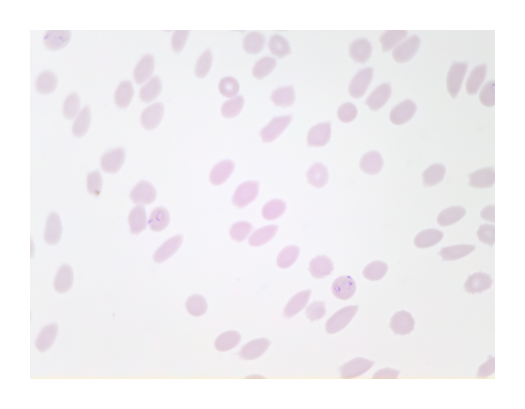

In [16]:
# cralws folder for files ending with .jpeg

def get_jpeg(path):
    list_jpeg = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpeg"):
                jpeg_path = os.path.join(root, file)
                list_jpeg.append(jpeg_path)
    return list_jpeg

org_files = get_jpeg('../data/Openflexure/Openflexure_Felix/Openflexure_images_felix_small')
org_files

# view 1 image
img = io.imread(org_files[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [17]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [18]:
# img_height = 1024
# img_width = 1024
# img_channels = 3
# imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
# sizes_imgs_red = []
# for idx, img in enumerate(imgs):
#     img_red = cv2.resize(img, (img_height, img_width))
#     #Append image to numpy array
#     imgs_red[idx] = img_red
#     #Append image shape to numpy array
#     sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [19]:
imgs_red = imgs

In [20]:
imgs_red[0].shape

(2464, 3280, 3)

In [21]:
# helper function to create list of lists of x, y per polygon per image
# input: a list created by helper function outlines_list from cellpose package

def outlines_to_x_y(outlines):
    arr_x = []
    arr_y = []
    for cell in outlines:
        arr_x.append(cell.flatten()[::2])
        arr_y.append(cell.flatten()[1::2])
    return arr_x, arr_y


In [22]:
# function cellpose_to_vgg which executes cellpose per image and returns polygons in a list ready for import to VGG 2.0 
# inputs: imgs = list of images, diameter = avg. diameter of cells

def cellpose_to_vgg(imgs, diameter):
    region = []
    img_len = len(imgs)
    model = models.Cellpose(gpu=True, model_type='cyto')
    masks_all = []
    count = 0

    for i in range(img_len):
        chan = [0, 0] # for black and white imgs
        masks, flows, styles, diams = model.eval(imgs[i], 
                                     diameter= diameter, 
                                     channels=chan,
                                     invert = True,
                                     flow_threshold = 1)
        masks_all.append(masks)
        outlines_ls = outlines_list(masks_all[i])
        out_len = len(outlines_ls)
        x, y = outlines_to_x_y(outlines_ls)
        for j in range(out_len):
            region_temp = []
            region_temp.append(org_files[i].split("/")[-1]) #filename 
            region_temp.append(Path(org_files[i]).stat().st_size) #file_size
            region_temp.append('{}') #file_attributes
            region_temp.append(out_len) #region_count
            region_temp.append(count) #region_id
            region_temp.append(str("{\"name\":\"polygon\",\"all_points_x\":["+','.join([str(i) for i in x[j]])+"],\"all_points_y\":["+','.join([str(i) for i in y[j]])+"]}"))  #region_shape_attributes
            region_temp.append('{\"RBC\":\"uninfected\"}') #region_attributes
            region.append(region_temp)
            count += 1 #count for region_id
    return region

In [23]:
# call cellpose_to_vgg

diameter = 170
region = cellpose_to_vgg(imgs, diameter)


** TORCH CUDA version installed and working. **
>>>> using GPU
processing 1 image(s)
time spent: running network 0.60s; flow+mask computation 0.81
estimated masks for 1 image(s) in 1.71 sec
>>>> TOTAL TIME 1.71 sec
processing 1 image(s)
time spent: running network 0.55s; flow+mask computation 0.92
estimated masks for 1 image(s) in 1.78 sec
>>>> TOTAL TIME 1.78 sec
processing 1 image(s)
time spent: running network 0.55s; flow+mask computation 1.05
estimated masks for 1 image(s) in 1.90 sec
>>>> TOTAL TIME 1.90 sec
processing 1 image(s)
time spent: running network 0.56s; flow+mask computation 0.87
estimated masks for 1 image(s) in 1.73 sec
>>>> TOTAL TIME 1.73 sec
processing 1 image(s)
time spent: running network 0.57s; flow+mask computation 0.81
estimated masks for 1 image(s) in 1.77 sec
>>>> TOTAL TIME 1.77 sec
processing 1 image(s)
time spent: running network 0.56s; flow+mask computation 0.81
estimated masks for 1 image(s) in 1.69 sec
>>>> TOTAL TIME 1.70 sec
processing 1 image(s)
tim

In [24]:
# create pd Data Frame and store as csv

df_region=pd.DataFrame(region,columns=['filename','file_size','file_attributes','region_count','region_id','region_shape_attributes','region_attributes'])

df_region.to_csv('../data/Openflexure/Openflexure_Felix/Openflexure_images_felix_small/poly_annotation.csv', index = False)